In [28]:
import numpy as np
import pandas as pd
import requests
import networkx as nx
import random
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from itertools import combinations
import seaborn as sns

In [3]:
url = "https://crowding.data.tfl.gov.uk/NUMBAT/NUMBAT%202023/NBT23FRI_outputs.xlsx"

r = requests.get(url)
with open("NBT23FRI_outputs.xlsx", "wb") as f:
    f.write(r.content)

xls = pd.ExcelFile("NBT23FRI_outputs.xlsx")
print(xls.sheet_names)

['_Cover', 'Link_Loads', 'Link_Frequencies', 'Line_Boarders', 'Station_Flows', 'Station_Entries', 'Station_Exits', 'Station_Boarders', 'Station_Alighters']


## Monte Carlo-Based Route Simulation

To capture realistic patterns of passenger movement within the London Underground network, we implemented a Monte Carlo simulation pipeline. A directed graph was first constructed from station-to-station flow data, with each edge weighted by total passenger volume. Transfer behavior at interchange stations was modeled probabilistically, allowing random transitions between lines based on a predefined switching probability.

In our simulation, transfer behavior at interchange stations was modeled using a fixed 30% probability, representing a moderate level of assumed switching. While not derived from a specific empirical study, this value reflects conventions commonly adopted in agent-based transport simulations where detailed behavioral data is unavailable (Zheng et al., 2013). Transitions along transit links were weighted by observed station-to-station passenger volumes, ensuring that, despite the assumed transfer heuristic, route choices remain largely governed by observed flow patterns.

To prevent overly complex or unrealistic passenger paths, each simulated journey was capped at five steps (i.e., up to five transfers). This aligns with empirical findings from TfL and other urban transit studies, which suggest that most passengers make fewer than 3-5 transfers per trip (Zhong et al., 2014; Nagel et al., 2007).

We conducted 30,000 simulations, using a fixed random seed to ensure reproducibility. Each simulated route began at a station selected in proportion to its observed entry volume, and proceeded step by step, with each subsequent station drawn from a weighted distribution informed by observed link flows and the 30% transfer probability. This stochastic framework captures both dominant travel behaviors and realistic variation in passenger routing.

After the simulation, we extracted all origin-destination (OD) pairs and computed their occurrence frequencies. To focus on consistently recurring travel patterns, we retained only those OD pairs that appeared 15 times or more across the 30,000 simulations. This threshold was chosen based on the highly skewed frequency distribution of OD pairs, allowing us to exclude extremely rare, potentially random routes and concentrate the analysis on statistically meaningful patterns.

_References:_  
_Zheng, H., Son, Y.-J., Chiu, Y.-C., Head, L., Feng, Y., Xi, H., Kim, S., & Hickman, M. (2013). A Primer for Agent-Based Simulation and Modeling in Transportation Applications. U.S. Department of Transportation, Federal Highway Administration, Office of Operations Research and Development. https://trid.trb.org/view/1278955._  
_Zhong, C., Arisona, S. M., Huang, X., Batty, M., & Schmitt, G. (2014). Detecting the dynamics of urban structure through spatial network analysis. International Journal of Geographical Information Science, 28(11), 2178-2199. https://doi.org/10.1080/13658816.2014.914521_  
_Nagel, K., & Marchal, F. (2007). Computational methods for multi-agent simulations of travel behavior. https://www.researchgate.net/publication/239538480_Computational_methods_for_multi-agent_simulations_of_travel_behavior_  

**Note:**  
In the early stage of our analysis, we used the `Link_Load` data to simulate approximately 30,000 complete passenger trajectories through the London Underground. This was intended to reflect realistic travel paths and network usage patterns.

However, as the focus of the project shifted toward origin-destination (OD) pair analysis—particularly to identify high-frequency start-end combinations for accessibility improvement—the simulation results were summarized at the OD level.

While `Station_Flow` provides platform-level detail—including movement types (Board, Alight, Interchange), line directions (e.g., "Piccadilly // WB"), and time periods—it lacks explicit, end-to-end directional pairing between origin and destination stations. Although individual segments can be interpreted manually, reconstructing full journeys requires assumptions across interchanges, as the dataset does not contain sequential trip logic or passenger paths across multiple stations.

For our Monte Carlo simulation, which involved scalable generation of realistic passenger journeys, we required a dataset that naturally supports path-based modeling at the OD level. Therefore, we selected `Link_Loads` as our core data source. Unlike `Station_Flow`, `Link_Loads` directly encodes station-to-station passenger volumes along transit links, providing a clearer structure for constructing a weighted, directed graph of the network.

_Given the feedback from Christine, we plan to clarify something in the "Limitations and Future Improvements" section of our final report._  


**Limitations:**  
Despite the overall effectiveness of the proposed framework, the Monte Carlo-based route simulation inevitably presents certain limitations. A key issue is the discrepancy between simulated route frequencies and actual passenger counts from observed data. For example, some origin–destination pairs that occur frequently in the simulation are associated with comparatively low exit volumes in reality. This divergence is largely due to the absence of complete, end-to-end journey records in the available datasets, which required the adoption of simplified behavioural assumptions—most notably a fixed transfer probability at interchange stations. In addition, the simulation does not account for other influential factors such as passenger route preferences, operational disruptions, or real-time crowding conditions. These constraints may limit the accuracy of the simulated results; nevertheless, the outcomes remain useful for comparative accessibility assessment and for informing subsequent spatial optimisation experiments.

**Future Improvements:**  
Future work could enhance the reliability of the simulation by incorporating richer behavioural and operational datasets. Integrating smart card transaction records or other high-resolution passenger tracking data would allow for more accurate modelling of end-to-end journeys and transfer patterns. The fixed transfer probability could be replaced with empirically derived values that vary by station, line, or time period, reflecting observed traveller behaviour. Additionally, coupling the simulation with dynamic network conditions—such as service disruptions, congestion effects, and scheduled headways—would improve its ability to replicate realistic travel patterns. From a methodological perspective, machine learning–based route choice models could be applied to better capture complex decision-making processes, thereby narrowing the gap between simulated and observed travel behaviour.

_(Optional)_ Moreover, the current implementation handles missing station entries by automatically including them to prevent simulation interruptions, followed by manual review when mismatches are detected. While this approach ensures robustness, it could be simplified by applying straightforward data preprocessing techniques to harmonize station names and ensure dataset completeness before simulation. Such preprocessing would reduce the need for manual intervention and improve the efficiency of the workflow.

In [4]:
df_links = pd.read_excel(xls, sheet_name="Link_Loads", header=2)
df_flows = pd.read_excel(xls, sheet_name="Station_Flows", header=2)
df_entries = pd.read_excel(xls, sheet_name="Station_Entries", header=2)
df_exits = pd.read_excel(xls, sheet_name="Station_Exits", header=2)
df_boarders = pd.read_excel(xls, sheet_name="Station_Boarders", header=2)
df_alighters = pd.read_excel(xls, sheet_name="Station_Alighters", header=2)

# Extract a list of interchange station names from flow data
def extract_interchange_stations(df_flows):
    interchange_rows = df_flows[df_flows["Movement"].str.contains("Interchange", na=False)]
    interchange_stations = interchange_rows["To Station"].dropna().unique().tolist()
    return interchange_stations

# # Construct a directed graph where nodes are stations and edges represent flows
# def build_graph_from_links(df_links, entry_stations=None, exit_stations=None):
#     G = nx.DiGraph()
#     for _, r in df_links.iterrows():
#         # Add edge with weight = flow volume
#         G.add_edge(r["From Station"], r["To Station"], weight=r["Total"])
#     # Ensure all entry and exit stations are included in the graph.
#     # This step prevents missing nodes when some stations appear only in df_entries/df_exits
#     # but not in the link-level flow data (df_links). Without this, the graph G may be incomplete, 
#     # leading to simulation errors or missing routes.
#     if len(entry_stations) > 0:
#         for station in entry_stations:
#             if station not in G:
#                 G.add_node(station)
#     if len(exit_stations) > 0:
#         for station in exit_stations:
#             if station not in G:
#                 G.add_node(station)
#     return G

# Construct a directed graph where nodes are stations and edges represent flows
def build_graph_from_links(df_links, entry_stations=None, exit_stations=None):
    G = nx.DiGraph()
    
    from_stations = set()
    to_stations = set()

    for _, r in df_links.iterrows():
        # Add edge with weight = flow volume
        from_stations.add(r["From Station"])
        to_stations.add(r["To Station"])
        G.add_edge(r["From Station"], r["To Station"], weight=r["Total"])

    # Flag suspicious station names not in df_links
    if entry_stations is not None and len(entry_stations) > 0:
        missing_entries = [s for s in entry_stations if s not in from_stations and s not in to_stations]
        if missing_entries:
            print(f"[Warning] Entry stations not found in df_links: {missing_entries}")
    if exit_stations is not None and len(exit_stations) > 0:
        missing_exits = [s for s in exit_stations if s not in from_stations and s not in to_stations]
        if missing_exits:
            print(f"[Warning] Exit stations not found in df_links: {missing_exits}")

    # Still add them to avoid simulation errors (but now at least can know which are missing)
    # Note: To avoid simulation interruptions, we ensured all entry and exit stations are included in the graph 
    # even if not found in the Link_Loads dataset. 
    # However, a warning is printed when mismatched names are detected, 
    # helping us identify possible inconsistencies in station naming (e.g., Camden Town vs Camden Town LU). 
    # These are manually reviewed and corrected where necessary.
    if entry_stations is not None and len(entry_stations) > 0:
        for station in entry_stations:
            if station not in G:
                G.add_node(station)
    if exit_stations is not None and len(exit_stations) > 0:
        for station in exit_stations:
            if station not in G:
                G.add_node(station)

    return G

def build_entry_weights(df_entries):
    entries = df_entries[["Station", "Total"]].dropna()
    return dict(zip(entries["Station"], entries["Total"]))

def build_exit_weights(df_exits):
    exits = df_exits[["Station", "Total"]].dropna()
    return dict(zip(exits["Station"], exits["Total"]))

# Create dictionaries for total boardings and alightings per station
def build_board_alight_dicts(df_boarders, df_alighters):
    board_dict = df_boarders.groupby("Station")["Total"].sum().to_dict()
    alight_dict = df_alighters.groupby("Station")["Total"].sum().to_dict()
    return board_dict, alight_dict

# Simulate a single route starting from a given station
# Incorporates random transfers at interchange stations and weighted moves based on flow

# max_transfers controls the maximum number of inter-line transfers in a simulated route.
# A value of 5 reflects typical commuter behavior, where most metro users make fewer than 3-5 transfers per journey.
# This cap avoids overly complex routes while preserving realistic trip patterns and ensuring computational efficiency.

# transfer_prob: assumed probability that a passenger will transfer at an interchange station (30%).
# This is consistent with agent-based modeling practices where detailed behavioral data is unavailable,
# and was referenced from heuristics in Zheng et al. (2013).
def simulate_route(G, start, interchange_list, board_dict, alight_dict,
                   max_transfers=5, transfer_prob=0.3):

    path = [start]
    cur = start
    score = 0
    transfer_count = 0 # New: transfer count to limit transfers

    while transfer_count < max_transfers:
        # Possibly transfer at interchange stations based on probability
        if cur in interchange_list and random.random() < transfer_prob:
            candidates = [s for s in G.successors(cur) if s in interchange_list and s not in path]
            if candidates:
                # Transfers at interchange stations are chosen uniformly at random among possible successors.
                # This reflects the lack of detailed transfer preference data.
                nxt = random.choice(candidates)
                path.append(f"[TRANSFER→]{nxt}")
                cur = nxt
                transfer_count += 1 
                continue

        if cur not in G:
            break
        # If no transfer occurs, choose among all successor stations not yet visited.
        # Interchange stations are not excluded here to allow for indirect transfers or returns.
        succ = [s for s in G.successors(cur) if s not in path]
        if not succ:
            break
        # Choose next station based on link weights (passenger volume)
        weights = [G[cur][s]["weight"] for s in succ]
        # If all weights are zero or if no successors remain, break the loop.
        # This ensures robustness against missing data or isolated nodes.
        if sum(weights) == 0 or len(weights) != len(succ):
            break
        cur = random.choices(succ, weights=weights, k=1)[0]
        path.append(cur)
        # Accumulate a score representing passenger flow intensity at each visited station.
        # The score is calculated as the sum of boardings and alightings; default = 0 ensures robustness for stations with missing data.
        # This metric can be used to evaluate how "popular" or realistic a simulated route is, supporting downstream analysis or prioritization.
        score += board_dict.get(cur, 0) + alight_dict.get(cur, 0)
    return path, score

# Run multiple route simulations and collect results
def run_simulation_pipeline(df_links, df_flows, df_entries, df_exits, df_boarders, df_alighters,
                            num_routes=10000):
    
    interchange_stations = extract_interchange_stations(df_flows)
    entry_stations = df_entries["Station"].dropna().unique()
    exit_stations = df_exits["Station"].dropna().unique()
    start_stations = df_entries.sort_values(by="Total", ascending=False)["Station"].tolist()
    end_stations = df_exits.sort_values(by="Total", ascending=False)["Station"].tolist()
    G = build_graph_from_links(df_links, entry_stations, exit_stations)
    entry_weights = build_entry_weights(df_entries)
    exit_weights = build_exit_weights(df_exits)
    board_dict, alight_dict = build_board_alight_dicts(df_boarders, df_alighters)

    starts = list(entry_weights.keys())
    raw_weights = np.array([entry_weights[s] for s in starts])

    # Convert raw weights to log scale to reduce skewness and improve numerical stability
    log_weights = np.log1p(raw_weights)
    entry_weights = dict(zip(starts, log_weights))
    weights = list(entry_weights.values())

    routes = []
    scores = []
    ends = []

    for _ in range(num_routes):
        start = random.choices(starts, weights=weights, k=1)[0]
        path, score = simulate_route(G, start, interchange_stations, board_dict, alight_dict)
        routes.append(path)
        scores.append(score)
        # Remove transfer tags to get clean end station
        clean_path = [step for step in path if not str(step).startswith("[TRANSFER")]
        end = clean_path[-1] if len(clean_path) >= 2 else None
        ends.append(end)

    df_result = pd.DataFrame({
        "Route": routes,
        "Score": scores,
        "End": ends
    })

    df_result["End Exit Volume"] = df_result["End"].map(exit_weights)

    df_result["Start"] = df_result["Route"].apply(lambda x: x[0] if len(x) > 0 else None)
    df_result = df_result[df_result["Start"].isin(start_stations) & df_result["End"].isin(end_stations)]

    return df_result

def plot_route_pair_frequencies(df_result):
    # Although the initial design aimed at visualizing top simulated routes on a network map (which required a string-based "Route_Pair"), 
    # the project focus was later refined toward OD-pair-based analysis and accessibility optimization. 
    # Nevertheless, the "Route_Pair" representation remains useful for summarizing and ranking simulated OD pairs by frequency,
    # which supports our selection of key pairs for further optimization comparison.
    # Create a combined Start-End key for each route
    df_result["Route_Pair"] = df_result["Start"] + " → " + df_result["End"]

    # Count frequency of each unique Start-End pair
    pair_counts = df_result["Route_Pair"].value_counts().reset_index()
    pair_counts.columns = ["Route_Pair", "Count"]

    # Sort by frequency descending
    pair_counts = pair_counts.sort_values(by="Count", ascending=False).reset_index(drop=True)

    # Plot the frequencies as a line chart
    plt.figure(figsize=(14, 6))
    plt.plot(range(len(pair_counts)), pair_counts["Count"], marker='o', linewidth=1.5)
    plt.title("Frequency of Simulated Start-End Route Pairs", fontsize=14)
    plt.xlabel("Route Pair Rank (sorted by frequency)", fontsize=12)
    plt.ylabel("Number of Simulated Occurrences", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

**Note:**  

In this simulation, we did not explicitly constrain the route to end at a known exit station. Instead, we capped the number of inter-line transfers to five, reflecting common travel patterns observed in large-scale transport studies (Zhong et al., 2014; Nagel et al., 2007). This cap allows journeys to continue through many stations as long as the number of transfers remains within realistic limits, avoiding overly complex or unlikely paths.

The final station in each simulated path does not represent a literal exit, but a plausible stopping point after a realistic sequence of transfers. This abstraction aligns with our goal of identifying high-likelihood route segments, rather than precisely modeling exit behavior.

As the primary aim of this simulation is to uncover typical routing patterns between entry points and potential destinations, rather than exact OD pairs, this approximation is considered suitable for OD-based accessibility analysis.

Moreover, the station exit dataset reflects "typical day" flows with major disruptions and anomalies removed. While this improves consistency, it may under-represent less frequent patterns—such as low-traffic or off-peak exits. Enforcing termination at these stations could introduce bias or exclude valid journeys. To mitigate this, we allow routes to end organically after a capped number of transfers, using `max_transfers` as a practical constraint.

To capture the variability and distribution of possible travel routes in a realistic manner, we employed a Monte Carlo simulation approach. A total of 30,000 simulation runs were conducted. This number was selected as a balance between computational efficiency and statistical robustness.
  
According to the law of large numbers and the central limit theorem, the accuracy of Monte Carlo estimates improves at a rate of O(1/N^(1/2)), where N is the number of samples. In practical terms, increasing the number of runs from 10,000 to 30,000 reduces the expected standard error by approximately 42%, which significantly improves the stability of the estimated route frequency distribution without incurring excessive computational cost.
  
Furthermore, as discussed in Glasserman (2003) and Rubinstein & Kroese (2016), simulation sizes in the range of 10,000 to 100,000 are typically sufficient for modeling aggregate behaviors in large-scale stochastic systems, such as transportation networks. Therefore, we consider 30,000 simulations appropriate for capturing the dominant patterns in route choices and interchange behaviors within our data-driven model.
  
_References:_  
_Glasserman, P. (2003). Monte Carlo Methods in Financial Engineering. Springer_  
_Rubinstein, R. Y., & Kroese, D. P. (2016). Simulation and the Monte Carlo Method (3rd ed.). Wiley_

In [12]:
random.seed(2025)  # Set seed for reproducibility

df_result = run_simulation_pipeline(
    df_links, df_flows, df_entries, df_exits,
    df_boarders, df_alighters,
    num_routes = 30000
    )

display(df_result.head(20))

[Warning] Entry stations not found in df_links: ['Camden Town', 'Kennington']
[Warning] Exit stations not found in df_links: ['Camden Town', 'Kennington']


,Route,Score,End,End Exit Volume,Start
0,"[Marylebone LU, Edgware Road (Bak), [TRANSFER→...",1.915161e+06,Stockwell,11418.710499,Marylebone LU
1,"[Burnt Oak, Edgware]",1.334343e+04,Edgware,6604.488171,Burnt Oak
2,"[Wimbledon Park, Southfields, East Putney, Put...",1.730589e+06,King's Cross St. Pancras,122827.765441,Wimbledon Park
3,"[Langdon Park, Devons Road, Bow Church, Puddin...",7.089259e+05,Canary Wharf EL,23414.970073,Langdon Park
4,"[Westferry, Limehouse DLR, Shadwell DLR, Bank ...",1.531277e+06,Angel,21339.307030,Westferry
5,"[Shenfield, Brentwood, Harold Wood, Gidea Park...",1.039973e+06,Barking,25951.668285,Shenfield
6,"[Bushey, Carpenders Park, Hatch End, Headstone...",9.021720e+04,Harlesden,4415.004122,Bushey
7,"[London Bridge LU, Bank and Monument, Liverpoo...",2.506706e+06,Hammersmith (DIS),30293.731838,London Bridge LU
8,"[Barking Riverside, Barking, Upney, Becontree,...",1.944881e+06,Oxford Circus,88888.967042,Barking Riverside
9,"[West Croydon NR, Norwood Junction, [TRANSFER→...",1.590035e+04,Sydenham,4847.996232,West Croydon NR


### Visualization and Evaluation

In [ ]:
def build_pair_stats(df_result):
    if "Route_Pair" not in df_result.columns:
        df_result["Route_Pair"] = df_result["Start"] + " → " + df_result["End"]

    pair_stats = (
        df_result.groupby("Route_Pair")
                 .agg(count=("Route_Pair", "size"),
                      mean_score=("Score", "mean"),
                      median_score=("Score", "median"),
                      start=("Start", "first"),
                      end=("End", "first"))
                 .sort_values("count", ascending=False)
                 .reset_index()
    )

    pair_stats["rank"] = range(1, len(pair_stats) + 1)
    return pair_stats

def plot_score_distribution(df_result, bins=40):
    plt.figure(figsize=(10, 4.5))
    plt.hist(df_result["Score"], bins=bins)
    plt.title("Distribution of Route Scores")
    plt.xlabel("Score (boarders + alighters along the route)")
    plt.ylabel("Number of Simulated Routes")
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

    desc = df_result["Score"].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])
    print("Score summary:\n", desc)

def topk_table(pair_stats, k=20):
    cols = ["rank", "Route_Pair", "count", "mean_score", "median_score", "start", "end"]
    tbl = pair_stats[cols].head(k)
    print(tbl.to_string(index=False))
    return tbl

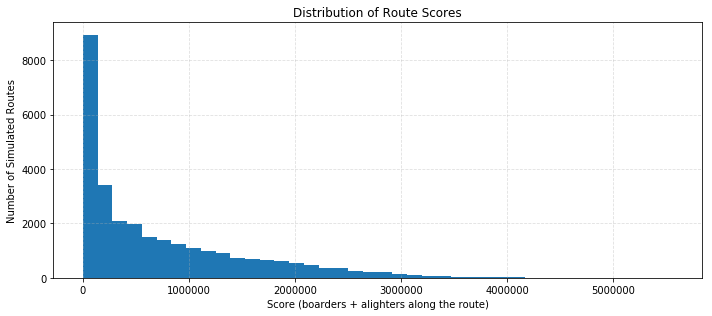

Score summary:
 count    2.919300e+04
mean     7.372868e+05
std      8.059113e+05
min      1.653245e+03
10%      3.128738e+04
25%      1.025049e+05
50%      4.306954e+05
75%      1.152010e+06
90%      1.956541e+06
max      5.559820e+06
Name: Score, dtype: float64


In [ ]:
pair_stats = build_pair_stats(df_result)
plot_score_distribution(df_result)

The histogram illustrates the distribution of route scores, where the score is defined as the total number of boarders and alighters along the simulated route. The distribution is highly right-skewed, with the majority of simulated routes concentrated at relatively low scores (below 0.5 million), while a small number of routes achieve scores above 2 million. This indicates that while most OD pairs involve moderate passenger flows, a limited set of "popular" routes attract disproportionately high ridership.

The accompanying statistical summary confirms this skewness: the mean score (737,287) is notably higher than the median (430,695), and the 90th percentile score (1,956,541) is more than four times the median. Such a pattern is consistent with typical urban transport demand, where a few high-demand corridors carry a large share of total passengers.

In [16]:
top20 = topk_table(pair_stats, k = 20)

 rank                          Route_Pair  count     mean_score   median_score             start               end
    1     Canary Wharf DLR → Lewisham DLR     50  114440.120143  113522.568994  Canary Wharf DLR      Lewisham DLR
    2              Custom House → Beckton     46   33924.198009   33924.198009      Custom House           Beckton
    3            Greenwich → Lewisham DLR     44   32116.902154   32116.902154         Greenwich      Lewisham DLR
    4                 Eastcote → Uxbridge     43   35883.918460   35883.918460          Eastcote          Uxbridge
    5         Turnpike Lane → Cockfosters     43   83337.145138   83337.145138     Turnpike Lane       Cockfosters
    6             South Woodford → Epping     42   78722.783041   54106.031303    South Woodford            Epping
    7           South Quay → Lewisham DLR     41   85290.339849   85290.339849        South Quay      Lewisham DLR
    8         Fulham Broadway → Wimbledon     40  123106.127560  123106.127560  

The table lists the top 20 origin-destination (OD) pairs ranked by their simulated frequency. These pairs represent the most commonly generated journeys in the simulation, with counts ranging from 34 to 50. Several OD pairs, such as Canary Wharf DLR → Lewisham DLR and Custom House → Beckton, show high simulation counts and relatively consistent mean and median scores, indicating stable performance across simulation runs.

End-station consistency: Pearson r=0.077 (p=0.216); Spearman ρ=0.237 (p=0.000104)
Stations compared: 262


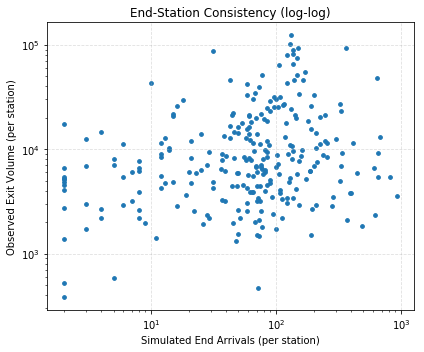

In [13]:
def evaluate_end_station_consistency(df_result, df_exits, min_count=1, log_plot=True):
   
    end_counts = (df_result["End"]
                  .dropna()
                  .value_counts()
                  .rename_axis("Station")
                  .reset_index(name="sim_end_count"))
    merged = end_counts.merge(df_exits[["Station","Total"]], on="Station", how="left")
    merged["Total"] = merged["Total"].fillna(0)

    merged = merged[merged["sim_end_count"] >= min_count].copy()

    r_p, p_p = pearsonr(merged["sim_end_count"], merged["Total"])
    r_s, p_s = spearmanr(merged["sim_end_count"], merged["Total"])
    print(f"End-station consistency: Pearson r={r_p:.3f} (p={p_p:.3g}); Spearman ρ={r_s:.3f} (p={p_s:.3g})")
    print(f"Stations compared: {len(merged)}")

    plt.figure(figsize=(6,5))
    plt.scatter(merged["sim_end_count"], merged["Total"], s=14)
    plt.xlabel("Simulated End Arrivals (per station)")
    plt.ylabel("Observed Exit Volume (per station)")
    plt.title("End-Station Consistency: Simulation vs. Observed Exits")
    if log_plot:
        plt.xscale("log"); plt.yscale("log")
        plt.title("End-Station Consistency (log-log)")
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout(); plt.show()

    return merged

station_eval_end = evaluate_end_station_consistency(df_result, df_exits, min_count=2, log_plot=True)

The End-Station Consistency plot evaluates the alignment between simulated end-station arrivals and the observed exit volumes. The Pearson correlation coefficient is relatively low (0.077, not statistically significant), while the Spearman rank correlation is slightly higher (0.237, statistically significant). These results indicate that the simulation does not closely replicate the real-world distribution of passenger destinations across stations.

Such discrepancies are not uncommon in transport simulations, which may result from the absence of complex passenger behaviour modelling, trip-chaining patterns, and other real-world factors.

In this study, the subsequent p-median optimisation results are interpreted within the assumptions of the simulation environment, rather than as precise forecasts of actual passenger movements.

Start-station consistency: Pearson r=0.503 (p=5.15e-29); Spearman ρ=0.611 (p=2.74e-45)
Stations compared: 430


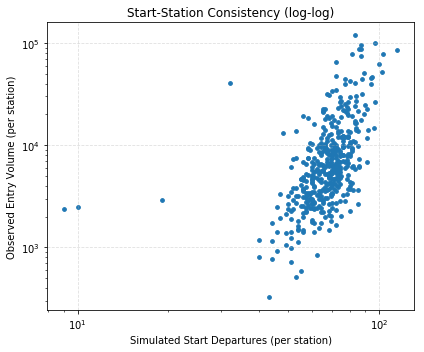

In [15]:
def evaluate_start_station_consistency(df_result, df_entries, min_count=1, log_plot=True):
   
   # Count simulated start station departures
    start_counts = (
        df_result["Start"]
        .dropna()
        .value_counts()
        .rename_axis("Station")
        .reset_index(name="sim_start_count")
    )

    # Merge with observed entry volumes
    merged = start_counts.merge(df_entries[["Station", "Total"]], on="Station", how="left")
    merged["Total"] = merged["Total"].fillna(0)

    # Filter by minimum simulated departures
    merged = merged[merged["sim_start_count"] >= min_count].copy()

    # Calculate correlation
    r_p, p_p = pearsonr(merged["sim_start_count"], merged["Total"])
    r_s, p_s = spearmanr(merged["sim_start_count"], merged["Total"])
    print(f"Start-station consistency: Pearson r={r_p:.3f} (p={p_p:.3g}); Spearman ρ={r_s:.3f} (p={p_s:.3g})")
    print(f"Stations compared: {len(merged)}")

    # Scatter plot
    plt.figure(figsize=(6, 5))
    plt.scatter(merged["sim_start_count"], merged["Total"], s=14)
    plt.xlabel("Simulated Start Departures (per station)")
    plt.ylabel("Observed Entry Volume (per station)")
    plt.title("Start-Station Consistency: Simulation vs. Observed Entries")
    if log_plot:
        plt.xscale("log"); plt.yscale("log")
        plt.title("Start-Station Consistency (log-log)")
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

    return merged

station_eval_start = evaluate_start_station_consistency(df_result, df_entries, min_count=2, log_plot=True)

The Start-Station Consistency plot evaluates the relationship between simulated start-station departures and the observed entry volumes. The Pearson correlation coefficient (0.503) and Spearman rank correlation (0.611) are both moderate and statistically significant, indicating that the simulation reproduces the relative departure volumes at stations reasonably well.

The clear upward trend in the log-log plot suggests that stations with higher observed entries also tend to have higher simulated departures, though some deviations are present. These deviations may be due to simplified assumptions in the simulation, such as the absence of detailed passenger route-choice heterogeneity, peak/off-peak temporal variations, or trip-chaining behaviours.

Compared with the weaker end-station consistency, the start-station results show better alignment with reality. The weaker end-station consistency may partly result from the simulation design, in which start stations were explicitly set while end stations were not fixed. Journeys were only constrained by a maximum transfer limit (five inter-line transfers), allowing passengers to reach a wide range of possible destinations. This design captures realistic variability in potential travel patterns but reduces the alignment with observed exit volumes.

d:\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2062: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
d:\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


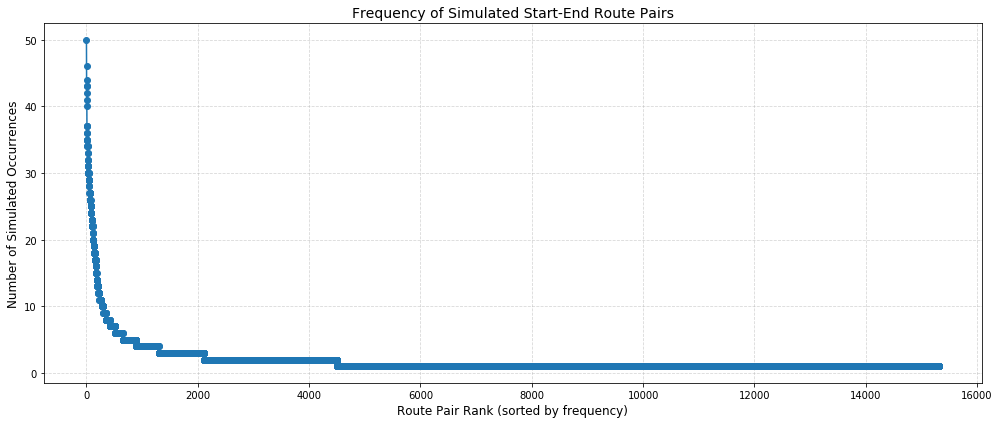

In [12]:
plot_route_pair_frequencies(df_result)

In order to identify the most representative and frequently used travel patterns from the Monte Carlo simulation, we define a route pair (start-end) as a popular route if it appears 15 times or more among the 30,000 simulated journeys. This threshold is based on the observation that while only a small number of start-end route pairs occurred repeatedly, the majority appeared just a few times. In other words, the distribution of route frequencies is highly uneven, with a long tail of rare combinations.
  
By selecting a cutoff of 15 occurrences, we strike a balance between statistical significance and data coverage. The selected route pairs are frequent enough to reflect recurring patterns, yet limited in number to allow focused downstream analysis. This approach avoids over-interpreting rare, potentially random combinations and centers the analysis on routes that consistently emerge in simulated travel behavior.

**Note:**  
The default value of min_occurrence = 15 is based on this long-tailed distribution observed across 30,000 simulated journeys. Setting it as a default parameter simplifies repeated function calls while maintaining consistent filtering logic throughout the analysis.

In [29]:
def count_frequent_route_pairs(df_result, min_occurrence = 15):
    df_result["Route_Pair"] = df_result["Start"] + " → " + df_result["End"]
    pair_counts = df_result["Route_Pair"].value_counts()
    frequent_pairs = pair_counts[pair_counts >= min_occurrence]
    print(f"Number of route pairs that occurred ≥ {min_occurrence} times: {len(frequent_pairs)}")
    return frequent_pairs

frequent_pairs = count_frequent_route_pairs(df_result)

Number of route pairs that occurred ≥ 15 times: 182


In [7]:
def save_frequent_route_pairs_split(df_result, min_occurrence = 15, filename = "frequent_routes.csv"):
    df_result["Route_Pair"] = df_result["Start"] + " → " + df_result["End"]
    pair_counts = df_result["Route_Pair"].value_counts()

    frequent_pairs = pair_counts[pair_counts >= min_occurrence].reset_index()
    frequent_pairs.columns = ["Route_Pair", "Count"]
    frequent_pairs[["Start_Station", "End_Station"]] = frequent_pairs["Route_Pair"].str.split(" → ", expand=True)
  
    output_df = frequent_pairs[["Start_Station", "End_Station", "Count"]]
    output_df.to_csv(filename, index=False)
    
    print(f"Saved {len(output_df)} frequent route pairs to '{filename}'")
    return output_df

frequent_routes = save_frequent_route_pairs_split(df_result, filename = "frequent_routes_final_2.0.csv")

Saved 182 frequent route pairs to 'frequent_routes_final_2.0.csv'


**Note:** The dataset `frequent_routes_final_2.0.csv`, containing 182 frequent OD pairs, will be used in the subsequent stage to collect travel time data for both step-free accessible and regular routes.

## Bus Stop Optimization via P-Median Approximation

To identify optimal locations for additional bus stops, we first formulated a simplified variant of the P-Median problem, with the objective of minimizing the total weighted walking cost across frequent OD (origin-destination) pairs, measured along accessible routes, derived from the simulated dataset. Each OD pair is weighted by its simulated user count, and penalized by its walking time unless covered by one of the selected new facilities (i.e., bus stops).
  
OD pairs with walking times exceeding a minimum threshold were treated as "underserved". For each such pair, if either the origin or destination is selected as a new bus stop, we assume the walking burden is substantially reduced to a nominal value (set to 1 minute). Otherwise, the full walking cost (i.e., walk_time × user count) is retained. The algorithm evaluates all combinations of up to p new stop locations and selects the one that minimizes the total weighted cost.
  
For the purpose of verifying the method's functionality, both the maximum number of new stops (p = 3) and the minimum walking time threshold (walk_time ≥ 16) were selected arbitrarily. These values were not intended to reflect real-world planning assumptions and carry no empirical significance. They will be further calibrated or replaced based on empirical data and literature-informed benchmarks in subsequent analyses.
  
The method relies on an exhaustive combinatorial search and is therefore limited to a small number of candidate facilities. However, it provides an interpretable and data-driven framework for evaluating the potential impact of targeted interventions in improving network accessibility.

In [ ]:
# def suggest_new_bus_stops_from_od_walk(df_od, max_new_stops = 3, min_walk_threshold = 5):
#     """
#     Suggest new bus stops based on OD pairs with high walk_time.
#     Expects df_od to contain: ['Start_Station', 'End_Station', 'Count', 'Walk']
#     """

#     # Step 1: Filter OD pairs with long walk times
#     df_long_walks = df_od[df_od["Walk"] >= min_walk_threshold].copy()
#     if df_long_walks.empty:
#         print("No OD pairs exceed the minimum walk threshold.")
#         return []

#     # Step 2: Expand station frequency as potential demand
#     candidate_nodes = set(df_long_walks["Start_Station"]).union(set(df_long_walks["End_Station"]))
#     print(f"Found {len(df_long_walks)} OD pairs with walk_time ≥ {min_walk_threshold}")
#     print(f"Candidate new stop locations: {len(candidate_nodes)} stations")

#     # Step 3: Try all combinations of new stop placements (brute-force, only for small-scale)
#     candidate_nodes = list(candidate_nodes)
#     best_total_cost = float("inf")
#     best_combo = None

#     for combo in combinations(candidate_nodes, max_new_stops):
#         total_cost = 0
#         for _, row in df_long_walks.iterrows():
#             u, v = row["Start_Station"], row["End_Station"]
#             count = row["Count"]
#             walk_time = row["Walk"]

#             # If this OD pair's start or end station is covered by a new bus stop,
#             # we assume the walking burden is significantly reduced (e.g., to 1 minute).
#             # Otherwise, we keep the original walk_time × number of users.
#             if u in combo or v in combo:
#                 total_cost += 1 * count
#             else:
#                 total_cost += walk_time * count

#         if total_cost < best_total_cost:
#             best_total_cost = total_cost
#             best_combo = combo

#     print(f"Suggested new bus stop locations (up to {max_new_stops}):")
#     print(best_combo)
#     print(f"Total weighted walk cost reduced to: {best_total_cost:.2f}")

#     return best_combo

In [ ]:
# df_od = pd.read_csv("frequent_routes_final_new.csv")
# entry_stations = df_entries["Station"].dropna().unique()
# exit_stations = df_exits["Station"].dropna().unique()
# G = build_graph_from_links(df_links, entry_stations, exit_stations)
# suggest_new_bus_stops_from_od_walk(df_od, max_new_stops = 3, min_walk_threshold = 16)  # The numerical selection here is only to verify whether this code can run smoothly. Further changes will be made based on actual needs or literature support in the future.

[Warning] Entry stations not found in df_links: ['Camden Town', 'Kennington']
[Warning] Exit stations not found in df_links: ['Camden Town', 'Kennington']
Found 36 OD pairs with walk_time ≥ 16
Candidate new stop locations: 51 stations
Suggested new bus stop locations (up to 3):
('Shenfield', 'Watford Junction', 'Wimbledon')
Total weighted walk cost reduced to: 12157.00


('Shenfield', 'Watford Junction', 'Wimbledon')

We replaced the original walking-time-based cost with the total estimated travel time between each origin-destination pair, allowing for a more comprehensive reflection of real commuting burdens. For OD pairs whose origin or destination is covered by a new stop, the total time is reduced to a nominal value (e.g., 1 minute). All others retain their original total time. The optimization then selects the combination of up to p new stops that minimizes the weighted total commute time across all selected OD pairs.

Since the unified total travel time across OD pairs (rather than walking time alone) better captures user experience, we plan to use Google Maps API to obtain these values for the frequent OD pairs generated from simulation. A generic route-time estimation script is under development and being debugged. In the meantime, arbitrary values were used to test the algorithm pipeline.

In [ ]:
try:
    from rapidfuzz import process, fuzz
    _HAS_FUZZ = True
except Exception:
    _HAS_FUZZ = False


def normalize_name(s: str) -> str:
    """Lightweight normalizer for station names across datasets."""
    if pd.isna(s):
        return ""
    s = str(s).lower()
    junk = [
        " underground", " underground station", " station", " rail station",
        " (dlr)", " dlr", " lu", " tube", " elizabeth line", " overground"
    ]
    for j in junk:
        s = s.replace(j, "")
    for ch in [",", ".", "(", ")", "-", "–", "—", "/"]:
        s = s.replace(ch, " ")
    s = " ".join(s.split())
    return s


def load_facility_table(path_or_df):
    """
    Load facility table with columns (case-insensitive):
      'Station Name', 'Lift access', 'Main bus interchange'(optional)
    'Lift access' is 1 (yes) or NaN/blank (no).
    Returns DataFrame with:
      Station, has_lift (bool), name_norm
    """
    df = path_or_df if isinstance(path_or_df, pd.DataFrame) else pd.read_excel(path_or_df)

    cols = {c.lower().strip(): c for c in df.columns}
    st_col   = cols.get("station name")
    lift_col = cols.get("lift access")
    if not all([st_col, lift_col]):
        raise ValueError(f"Expect columns: 'Station Name' & 'Lift access'. Got: {list(df.columns)}")

    def one_to_bool(x):
        return True if (pd.notna(x) and (str(x).strip() in {"1", "true", "True"} or x == 1)) else False

    out = pd.DataFrame({
        "Station": df[st_col].astype(str),
        "has_lift": df[lift_col].map(one_to_bool),
    })
    out["name_norm"] = out["Station"].map(normalize_name)
    return out

def match_candidates_to_facility_lift_only(
    candidates,
    facility_df,
    score_cutoff=90,
    keep_condition="no_lift",
    keep_unmatched=False
):
    """
    Filter candidates based on facility table for lift access.
    """
    assert keep_condition in {"no_lift", "has_lift"}
    want = (keep_condition == "has_lift")

    filtered = []
    rows = []
    fac_names = facility_df["name_norm"].tolist()

    for s in candidates:
        s_norm = normalize_name(s)

        if _HAS_FUZZ:
            best = process.extractOne(
                s_norm, fac_names,
                scorer=fuzz.token_sort_ratio,
                score_cutoff=score_cutoff
            )
            if best:
                idx = best[2]
                rec = facility_df.iloc[idx]
                ok = (rec["has_lift"] == want)
                if ok:
                    filtered.append(s)
                rows.append({
                    "candidate": s,
                    "candidate_norm": s_norm,
                    "matched_station": rec["Station"],
                    "score": best[1],
                    "has_lift": rec["has_lift"],
                    "kept": bool(ok)
                })
            else:
                if keep_unmatched:
                    filtered.append(s)
                rows.append({
                    "candidate": s,
                    "candidate_norm": s_norm,
                    "matched_station": None,
                    "score": None,
                    "has_lift": None,
                    "kept": bool(keep_unmatched)
                })
        else:
            hit = facility_df[facility_df["name_norm"] == s_norm]
            if not hit.empty:
                rec = hit.iloc[0]
                ok = (rec["has_lift"] == want)
                if ok:
                    filtered.append(s)
                rows.append({
                    "candidate": s,
                    "candidate_norm": s_norm,
                    "matched_station": rec["Station"],
                    "score": 100,
                    "has_lift": rec["has_lift"],
                    "kept": bool(ok)
                })
            else:
                if keep_unmatched:
                    filtered.append(s)
                rows.append({
                    "candidate": s,
                    "candidate_norm": s_norm,
                    "matched_station": None,
                    "score": None,
                    "has_lift": None,
                    "kept": bool(keep_unmatched)
                })

    report = pd.DataFrame(rows)
    return filtered, report


def suggest_new_bus_stops_from_od_total(
    df_od,
    facility_df,
    max_new_stops=3,
    min_total_threshold=15,
    fuzzy_cutoff=90,
    keep_unmatched=False,
    keep_condition="no_lift",
):
    """
    Suggest new bus stops based on OD pairs with high total travel time.
    Expects df_od to contain: ['Start_Station', 'End_Station', 'Count', 'Total']
    facility_df: output of load_facility_table(...) 
    with 'has_lift' column.
    Only keep candidates that (by fuzzy match) have NO lift access.
    """
    # Step 1: Filter OD pairs with long total travel time
    df_long_travel = df_od[df_od["Total"] >= min_total_threshold].copy()
    if df_long_travel.empty:
        print("No OD pairs exceed the minimum total time threshold.")
        return tuple(), None

    # Step 2: Identify candidate stations from underserved OD pairs
    candidate_nodes = sorted(set(df_long_travel["Start_Station"]).union(df_long_travel["End_Station"]))
    print(f"Found {len(df_long_travel)} OD pairs with Total ≥ {min_total_threshold}")
    print(f"Raw candidate stations: {len(candidate_nodes)}")

    # Step 2.5: Apply lift-only facility filter via fuzzy matching
    filtered_candidates, match_report = match_candidates_to_facility_lift_only(
        candidate_nodes,
        facility_df,
        score_cutoff=fuzzy_cutoff,
        keep_condition=keep_condition,
        keep_unmatched=keep_unmatched
    )
    print(f"Candidates after lift-only filter ({keep_condition}): {len(filtered_candidates)}")

    if not filtered_candidates:
        print("No candidates remain after lift-only filter.")
        return tuple(), match_report

    # Step 3: Try all combinations of new stop placements (brute-force for small-scale test)
    k = min(max_new_stops, len(filtered_candidates))
    candidate_nodes = list(filtered_candidates)

    best_total_cost = float("inf")
    best_combo = None

    for combo in combinations(candidate_nodes, k):
        total_cost = 0.0
        for _, row in df_long_travel.iterrows():
            u, v = row["Start_Station"], row["End_Station"]
            count = row["Count"]
            total_time = row["Total"]

            # If either end is covered by a new stop, we reduce total time to 1 minute
            total_cost += (1 * count) if (u in combo or v in combo) else (total_time * count)

        if total_cost < best_total_cost:
            best_total_cost = total_cost
            best_combo = combo

    print(f"Suggested new bus stop locations (up to {max_new_stops}): {best_combo}")
    print(f"Total weighted travel cost reduced to: {best_total_cost:.2f}")

    return best_combo, match_report


In [30]:
df_od = pd.read_csv("frequent_routes_final_new.csv")
fac = load_facility_table("FINISH_station_facility.xlsx")

best_stops, match_report = suggest_new_bus_stops_from_od_total(
    df_od,
    facility_df=fac,
    max_new_stops=3,
    min_total_threshold=45, 
    fuzzy_cutoff=85,         
    keep_unmatched=True,
    keep_condition="no_lift"     
)

Found 66 OD pairs with Total ≥ 45
Raw candidate stations: 83
Candidates after lift-only filter (no_lift): 62
Suggested new bus stop locations (up to 3): ('Epping', 'High Barnet', 'West Ruislip')
Total weighted travel cost reduced to: 78711.00


**Note:**  
The dataset `frequent_routes_final_new.csv` was generated using the Jupyter Notebook titled `FINAL_wheelchair_accessible__commute_time.ipynb`. This script implemented a web scraping pipeline simulating user interactions on Google Maps, retrieving step-free (wheelchair accessible) total travel times for OD pairs listed in `frequent_routes_final_2.0.csv`.

The scraping was necessary because Google Maps API does not support querying wheelchair-accessible options directly. The output of the notebook forms the basis for the final accessibility-based stop optimization.

### Analysis of Selected Bus Stop Candidates from Travel Time Distributions  

To further investigate why certain stations-Epping, High Barnet, West Ruislip-were repeatedly selected as optimal candidates for new bus stops in the model, we examined their step-free travel time distributions from both origin and destination perspectives.

#### As Start Stations  

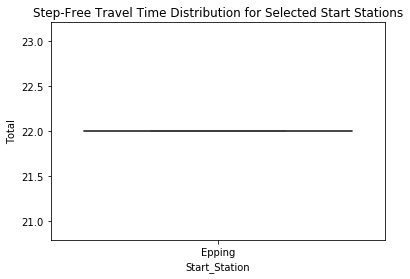

               count  mean  std   min   25%   50%   75%   max
Start_Station                                                
Epping           1.0  22.0  NaN  22.0  22.0  22.0  22.0  22.0


In [32]:
sns.boxplot(data=df_od[df_od["Start_Station"].isin(['Epping', 'High Barnet', 'West Ruislip'])],
            x="Start_Station", y="Total")
plt.title("Step-Free Travel Time Distribution for Selected Start Stations")
plt.show()

df_focus = df_od[df_od["Start_Station"].isin(['Epping', 'High Barnet', 'West Ruislip'])]
print(df_focus.groupby("Start_Station")["Total"].describe())

#### As End Stations  

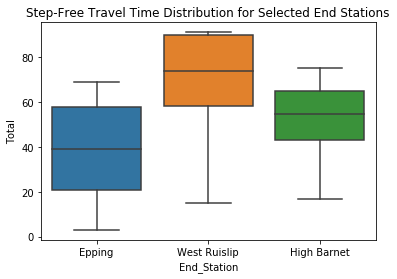

              count       mean        std   min    25%   50%    75%   max
End_Station                                                              
Epping         18.0  38.888889  21.986330   3.0  20.75  39.0  57.75  69.0
High Barnet    10.0  51.900000  17.546446  17.0  43.00  54.5  64.75  75.0
West Ruislip    9.0  65.777778  28.358322  15.0  58.00  74.0  90.00  91.0


In [38]:
sns.boxplot(data=df_od[df_od["End_Station"].isin(['Epping', 'High Barnet', 'West Ruislip'])],
            x="End_Station", y="Total")
plt.title("Step-Free Travel Time Distribution for Selected End Stations")
plt.show()

df_focus = df_od[df_od["End_Station"].isin(['Epping', 'High Barnet', 'West Ruislip'])]
print(df_focus.groupby("End_Station")["Total"].describe())

### Filtering Long-Distance Outliers  

While directional imbalance analysis revealed certain stations to be disproportionately costly as origins or destinations, further inspection of the updated OD statistics showed that a subset of OD pairs still exhibited unusually long step-free travel times. For example, while some stations like Epping had only a single short-distance record (22 minutes), other OD pairs—particularly involving West Ruislip—showed mean step-free travel times exceeding 65 minutes, with maximum values above 90 minutes. Such extremes, though valid, risk skewing the optimization process by directing the model’s focus toward a few distant pairs, at the expense of identifying improvements benefiting a broader user base.

To address this, we applied a **95th percentile threshold** on total step-free travel time, trimming the longest 5% of OD pairs. This ensures that:

1. Outlier-driven bias is reduced in the stop placement optimization.
2. Candidate stop suggestions are more spatially balanced.
3. The model focuses on improving the majority of realistic journeys, enhancing interpretability.

#### Statement about 95% Quantile for Travel Time Filtering

The longest 5% of routes (based on total travel time) were excluded to reduce the influence of extreme values. This choice is not dictated by a specific threshold in the literature, but follows a common practice in transport modeling to ensure robustness and eliminate outliers. Studies such as Geurs & van Wee (2004) and Papa & Bertolini (2015) have highlighted the distorting impact of rare long-distance journeys on accessibility metrics, and recommend percentile-based trimming as a defensible heuristic.

While the 95th percentile is not a universally "correct" cut-off, it strikes a pragmatic balance: removing the tail without excluding meaningful data.

_References:_  
_Geurs, K. T., & van Wee, B. (2004). Accessibility evaluation of land-use and transport strategies: Review and research directions. Journal of Transport Geography, 12(2), 127-140. https://doi.org/10.1016/j.jtrangeo.2003.10.005_  
_Papa, E., & Bertolini, L. (2015). Accessibility and transit-oriented development in European metropolitan areas. Journal of Transport Geography, 47, 70-83. https://doi.org/10.1016/j.jtrangeo.2015.07.003_

In [34]:
df_od = pd.read_csv("frequent_routes_final_new.csv")
# 95% quantile threshold for total travel time
threshold = df_od["Total"].quantile(0.95)
df_od_trimmed = df_od[df_od["Total"] <= threshold]
# Set max_new_stops to 3
best_stops, match_report = suggest_new_bus_stops_from_od_total(
    df_od_trimmed,
    facility_df=fac,
    max_new_stops=3,
    min_total_threshold=45, 
    fuzzy_cutoff=85,         
    keep_unmatched=True,
    keep_condition="no_lift"     
)

Found 56 OD pairs with Total ≥ 45
Raw candidate stations: 70
Candidates after lift-only filter (no_lift): 51
Suggested new bus stop locations (up to 3): ('Epping', 'High Barnet', 'West Ruislip')
Total weighted travel cost reduced to: 55763.00


### Parameter Settings Justification

To ensure the tractability and interpretability of the optimization process, we initially set the maximum number of new bus stops to three. This value is not theoretically fixed but serves as **a practical baseline for sensitivity analysis**, in which we intend to evaluate how different constraint levels (e.g., allowing 2, 4, 5, or more stops) impact overall accessibility improvements. This aligns with common practice in facility location problems, where budgetary or infrastructural limits are varied to assess cost–benefit trade-offs.

As for the minimum total travel time threshold, OD pairs with a regular journey duration shorter than 45 minutes were excluded. This filtering is guided by empirical conventions in urban transport research, where 30, 45, and 60 minutes are widely adopted as cut-off points to differentiate short, moderate, and long trips. These benchmarks are well established in datasets such as the London Travel Demand Survey (LTDS).

According to LTDS-a large-scale household travel diary survey conducted annually by Transport for London-commute durations are commonly categorized using thresholds like 30, 45, and 60 minutes (Travel in London 2023/2024; ITF, 2018). The use of a 45-minute threshold in this study is therefore consistent with recognized practice in accessibility and transport equity evaluations, allowing us to focus on journeys where time burdens are more pronounced and thus optimization interventions more impactful.

#### Sensitivity Analysis: Varying the Maximum Number of Additional Bus Stops

In [35]:
# Set max_new_stops to 2
best_stops, match_report = suggest_new_bus_stops_from_od_total(
    df_od_trimmed,
    facility_df=fac,
    max_new_stops=2,
    min_total_threshold=45, 
    fuzzy_cutoff=85,         
    keep_unmatched=True,
    keep_condition="no_lift"     
)

Found 56 OD pairs with Total ≥ 45
Raw candidate stations: 70
Candidates after lift-only filter (no_lift): 51
Suggested new bus stop locations (up to 2): ('Epping', 'High Barnet')
Total weighted travel cost reduced to: 62362.00


In [36]:
# Set max_new_stops to 4
best_stops, match_report = suggest_new_bus_stops_from_od_total(
    df_od_trimmed,
    facility_df=fac,
    max_new_stops=4,
    min_total_threshold=45, 
    fuzzy_cutoff=85,         
    keep_unmatched=True,
    keep_condition="no_lift"     
)

Found 56 OD pairs with Total ≥ 45
Raw candidate stations: 70
Candidates after lift-only filter (no_lift): 51
Suggested new bus stop locations (up to 4): ('Epping', 'High Barnet', 'Uxbridge', 'West Ruislip')
Total weighted travel cost reduced to: 51528.00


In [37]:
# Set max_new_stops to 5
best_stops, match_report = suggest_new_bus_stops_from_od_total(
    df_od_trimmed,
    facility_df=fac,
    max_new_stops=5,
    min_total_threshold=45, 
    fuzzy_cutoff=85,         
    keep_unmatched=True,
    keep_condition="no_lift"     
)

Found 56 OD pairs with Total ≥ 45
Raw candidate stations: 70
Candidates after lift-only filter (no_lift): 51


KeyboardInterrupt: 

### Optimization Results Summary: Minimizing Absolute Commute Time (Step-Free Routes, Lift-Only Filter)

To reduce the total travel burden for passengers relying on step-free accessible routes, we implemented a P-Median optimization model using absolute commute time (in minutes) as the cost metric. We filtered the OD pairs to retain only those with a total step-free travel time exceeding 45 minutes and falling below the 95th percentile (to exclude extreme outliers), yielding 56 high-priority OD pairs and 70 candidate stations for new bus stops. We then applied a lift-only filter to focus on stations without lift access, resulting in 51 candidate stations.

**Key findings:**

* **When allowing up to 2 new bus stops**, the model suggests: **Epping, High Barnet** → Total weighted commute cost reduced to: **62,362.00**

* **When allowing up to 3 new bus stops**, the model suggests: **Epping, High Barnet, West Ruislip** → Total weighted commute cost reduced to: **55,763.00**

* **When allowing up to 4 new bus stops**, the model suggests: **Epping, High Barnet, Uxbridge, West Ruislip** → Total weighted commute cost reduced to: **51,528.00**

These results show that strategically adding up to four bus stops at stations without lift access can substantially reduce the total weighted commute cost for step-free routes.

However, when attempting to optimize with 5 new stops, the function failed to complete even after several hours of computation, revealing a significant increase in complexity due to combinatorial explosion.

To address this, we plan to revise the cost function used in the optimization process by shifting from absolute commute time to more scalable metrics such as:

1. **Time difference** between regular and step-free routes
2. **Travel time ratio** (e.g., regular / step-free time)

This aims to better reflect accessibility disparities while reducing computational burden.